### Reto Empresarial- Ejercicio Fashion-MNIST- Daniel Afanador

In [1]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

train_files[0]

'./fashion-mnist/train/8/27542.png'

In [2]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(55000, 10000, 5000)

In [3]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [4]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [5]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

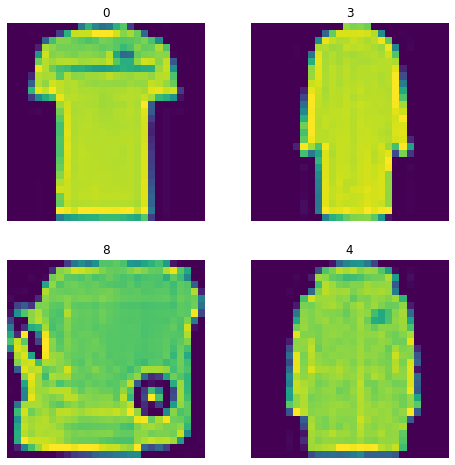

In [6]:
#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [7]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([55000, 28, 28])

In [8]:
import torch

batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [9]:
#--- Definimos el modelo CNN.

model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 8, kernel_size=7, stride=1, padding=3),
  #out: ((28-7+2*3)/1) + 1 = 28   -> 28 x 28 x 8

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  #out: 28/2 = 14                 -> 14 x 14 x 8

  torch.nn.Dropout(p=0.15), 

  torch.nn.Conv2d(8, 16, kernel_size=7, stride=1, padding=3),
  #out: ((14-5+2*2)/1) + 1 = 14   -> 14 x 14 x 16

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  #out: 14/2 = 7                 -> 7 x 7 x 16

  torch.nn.Dropout(p=0.1), 

  torch.nn.Flatten(),
  torch.nn.Linear(7*7*16, 10)
)
model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.1, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=784, out_features=10, bias=True)
)

## Para nuestro modelo CNN, consideramos un modelo semejante al realizado en clase, con diferencias marcadas en el tamaño del kernel ($7 \times 7$) y para el padding ($3 \times 3$). Se tienen nuevamente dos capas convolucionales, de forma tal que la primera capa tiene $8$ outputs, mientras que la segunda capa tiene $16$ salidas. Usando nuevamente capas de activación ReLU después de cada capa de convolución, se usan capas de MaxPooling debidas a una matriz de tamaño $2$ y un posterior Dropout (ligeramente distinto para cada capa de convolución) para desactivar cierto porcentaje de las neuronas usadas. Se tiene al final de este modelo $16$ imágenes de tamaño $7 \times 7$, que se compactan debido a una última capa lineal.

In [10]:
#--- Definimos los criterios de evaluación y el optmizador.

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

In [11]:
!pip install hiddenlayer

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


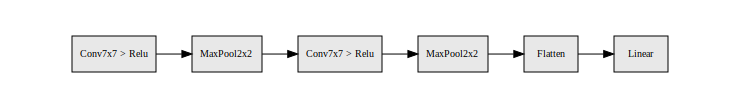

In [12]:
#--- Visualizamos la estructura de nuestra CNN.

import hiddenlayer as hl

hl.build_graph(model, torch.zeros([16,1,28,28]))

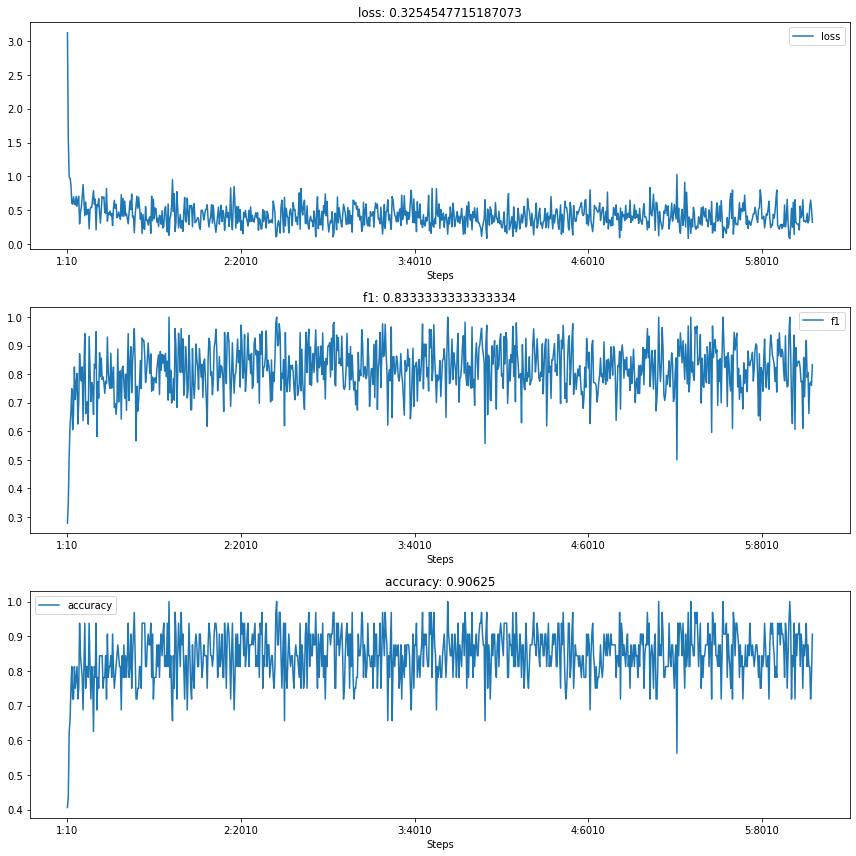

In [13]:
#--- Entrenamos la CNN

from sklearn.metrics import f1_score

n_epoch = 5

history = hl.History()
canvas = hl.Canvas()

iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()
    Xtr = X_train_batch.unsqueeze(1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)
    f1 = f1_score(Y_train_batch, Y_pred, average='macro')    

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%10 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, f1=f1, accuracy=acc)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["f1"])
          canvas.draw_plot(history["accuracy"])

## Notamos que los scores se dispersan a lo largo de un gran espectro valores en la medida que incrementa el número de épocas, lo que nos muestra que los parámetros escogidos para nuestro modelo no fueron óptimos para el desarrollo del mismo. No obstante, el score *loss* es lo suficientemente bajo como para evaluar que el modelo no pierde gran parte de la información que ha aprendido, mientras que los scores *f1* y *accuracy* se encuentran en buena medida cercanos a 0.9, lo que confirma que nuestra CNN interpreta con buena precisión gran parte de las imágenes de **fashion-mnist**.

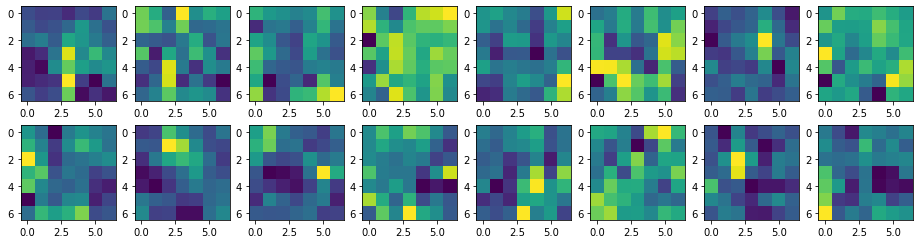

In [22]:
#-- Visualizando los mapas de características de la segunda capa convolucional.
kernels = list(model.children())[4].weight.detach()

fig = plt.figure(figsize=(16,4))
k = 0
for i in range(kernels.size(0)):
    plt.subplot(2,8,k+1)

    #-- Considerando que la segunda capa toma en cuenta 8 entradas, consideramos
    #-- arbitrariamente uno de los canales para hacer las gráficas de las 16 
    #-- imágenes resultantes. En este caso, usamos el canal "2" ([1]).

    plt.imshow(kernels[i][1].squeeze())
    k += 1
plt.show()

In [24]:
#-- Creamos la matriz de confusión
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

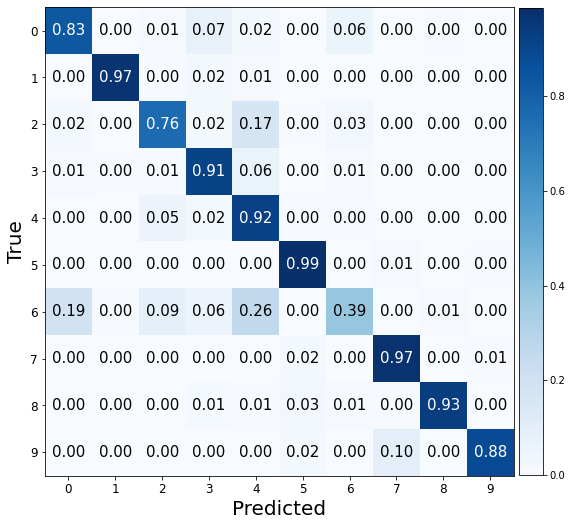

Loss:0.39, F1:0.85, Acc:0.85


In [25]:
#-- Validamos el modelo CNN por medio del set de testeo.

X_test, Y_test = X_test, Y_test
model.eval()
Xvl = X_test.unsqueeze(1)
Y_pred = model(Xvl)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test.cpu(), Y_pred.cpu(), average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)
CM(Y_test.cpu(), Y_pred.cpu(), 10)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

## Tras haber hecho una breve descripción del modelo CNN creado y ver algunas de sus características, usamos el set de testeo para ver como los scores y la matriz de confusión determinan el "performance" de nuestro modelo. De manera semejante a como se observó en las anteriores gráficas, la pérdida final es considerable, pero es lo sufcientemente baja para comprender que la CNN ha identificado correctamente los items de fashion. De forma análoga, en los scores de *f1* y *acc*, que son cercanos a 0.9, se observa que los parámetros del modelo pueden mejorarse, pero son lo suficientemente buenos como para crear una predicción coherente con el set de testeo.

## La matriz de confusión nos permite detallar a mayor profundidad las debilidades de nuestro modelo. La CNN presenta dificultades para diferenciar un item 6 (camisa) en relación a los items 0 (camisetas), los items 2 (suéteres) y a los items 4 (abrigos), lo cual muestra cierta coherencia con las dificultades que tendría un ser humano a la hora de diferenciar estas prendas. Por lo demás, la matriz de confusión nos confirma que nuestro modelo identifica y diferencia muy bien los demás items. Habiendo comprendido en buena medida el uso de las capas de convolución, se debe buscar en próximas instancias mejorar los parámetros y metaparámetros utilizados para complementar la eficiencia de la CNN.